# Machine learning sommelier: predicting a wine's quality from its physicochemical properties

#### Summary
While a wine's quality highly depends on a person's taste, some studies have tried to predict subjective wine ratings from objective physicochemical characteristics of the wine. The current project is yet another attempt to do so, in this case by relying on simple and commonly used machine learning models. A dataset was used containing information on several wines from both the red and white varieties of Portuguese vinho verde. For each wine, information was available on eleven physicochemical properties of the wine such as acidity, pH, or alcohol content, as well as a 0-to-10 quality rating made by taking the median of three individual ratings. We tried to predict quality ratings from the available physicochemical components by training a series of machine learning models on a training set via cross-validation. For each model type, we applied grid search to explore different hyparameter values. The model with the winning hyparameters was then retrained using the whole training data and then we evaluated model performance by making predictions on the test data. A random forest outperformed the rest of the models, which included linear regression, more complex linear models (ridge regression, lasso regression, recursive feature elimination, partial least squares regression, polynomial features) and a more sophisticated tree model (XGBoost). The winning random forest model predicted data relatively well, although it fared worse with extreme ratings. When examining the importance associated to the model's predictors, we found that higher quality was mainly associated with those wines with more alcohol, less density, less volatile acidity and, only for red wine, also more sulphates.

## 1. Load libraries
The initial step will be to load those general libraries we'll use for this project, including Numpy for math, Pandas for data wrangling and Matplotlib and Seaborn for data visualization. While we'll use other libraries for machine learning and stats, mainly Scikit-learn, these are big libraries with many modules, so we'll simply load the specific functions right before we need them. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Define graphical parameters
We'll now customize the way DataFrames are displayed, as well as some graphical elements for our figures, including image size, theme and color palettes.

In [2]:
#set max rows and columns when displaying data
pd.set_option('display.max_columns', None) #no maximum number of columns
pd.set_option('display.max_rows', 25) #maximum number of rows

#set font sizes
font_size_regular = 12
plt.rcParams.update({
    'font.size': font_size_regular + 2,
    'axes.labelsize': font_size_regular,
    'xtick.labelsize': font_size_regular - 2,
    'ytick.labelsize': font_size_regular - 2,
    'axes.titlesize': font_size_regular,
    'legend.title_fontsize': font_size_regular,
    'legend.fontsize': font_size_regular - 2,
    'figure.titlesize': font_size_regular + 2
})

#set plot sizes
plot_size_onerowwidth = 5 #width of a one-column figure
plot_size_onerowheight = 5 #height of a one-row figure

#define function to apply common settings to the axes
def apply_common_settings(ax):
    ax.spines['top'].set_visible(False)  #remove top spine
    ax.spines['right'].set_visible(False)  #remove right spine
    ax.spines['left'].set_linewidth(1)  #thickness of left spine
    ax.spines['bottom'].set_linewidth(1)  #thickness of bottom spine
    ax.tick_params(axis='both', which='both', width=1) #tick thickness

#define dictionary with wine types and respective colors to use as color palettes when plotting according to wine type
wine_palette_color = {"red": "#874343", "white": "#d0a15a"}
wine_palette_fill = {"red": "#964e6c", "white": "#e3d28b"}

## 3. Load datasets
The data we'll use for this project can be found at the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality). This dataset was used by [Cortez et al. on their paper](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377), where their goal was the same as ours. However, while they used deep learning techniques, we'll stick to some simple machine learning models. We'll first load the dataset for red wine and examine its format.

In [3]:
#load red wine dataset and assign it to DataFrame
df_wine_red = pd.read_csv('winequality-red.csv', sep = ';')

#display the DataFrame
display(df_wine_red)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


The dataset is very tidy and self-explanatory. Each of the 1599 rows is a wine, for which we have a series of columns with physicochemical properties, as well as a column with the quality rating. We'll now add a column labeling the type of wine.

In [4]:
#add first column labeling the type of wine
df_wine_red.insert(loc=0, column='wine_type', value='red')

#display the DataFrame
display(df_wine_red)

,wine_type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,red,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,red,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,red,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,red,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


We can next load the white wine dataset and follow the same steps we used for the red wine.

In [5]:
#load white wine dataset and assign it to DataFrame
df_wine_white = pd.read_csv('winequality-white.csv', sep = ';')

#add first column labeling the type of wine
df_wine_white.insert(loc=0, column='wine_type', value='white')

#display the DataFrame
display(df_wine_white)

,wine_type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,white,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,white,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,white,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,white,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Note that here we have 4898 rows, containing information on more wines than that for the red wine.

Since each wine is now labeled, we can concatenate both DataFrames into a single one.

In [6]:
#concatenate both DataFrames
df_wine = pd.concat([df_wine_red,df_wine_white])

#display the DataFrame
display(df_wine)

,wine_type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,white,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,white,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,white,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,white,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


I like to work with column names with no capital letters or spaces, where each word is separated with an underscore. Let's modify the column names to adhere to that format.

In [7]:
#rename columns
df_wine = df_wine.set_axis(['wine_type', 'fixed_acidity', 'volatile_acidity', 'citric_acid','residual_sugar','chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density','ph','sulphates','alcohol','quality'], axis=1)

#display the DataFrame
display(df_wine)

,wine_type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,white,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,white,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,white,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,white,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


While the columns are quite self-explanatory, it's always a good practice to know a bit more about the data they contain, and the unit in which they are.
- `wine_type`: character column indicating the variety of wine, either red or white.
- `fixed_acidity`: numeric column indicating fixed acidity, in  g(tartaric acid)/dm<sup>3</sup>
- `volatile_acidity`: numeric column indicating volatile acidity, in g(tartaric acid)/dm<sup>3</sup>
- `citric_acid`: numeric column indicating citric acid, in g/dm<sup>3</sup>
- `residual_sugar`: numeric column indicating residual sugar, in g/dm<sup>3</sup>
- `chlorides`: numeric column indicating chlorides, in g(sodium chloride)/dm<sup>3</sup>
- `free_sulfur_dioxide`: numeric column indicating free sulphur dioxide, in mg/dm<sup>3</sup>
- `total_sulfur_dioxide`: numeric column indicating total sulphur dioxide, in mg/dm<sup>3</sup>
- `density`: numeric column indicating density, in g/cm<sup>3</sup>
- `ph`: numeric column indicating pH
- `sulphates`: numeric column indicating sulphates, in g(potassium sulphate)/dm<sup>3</sup>
- `alcohol`: numeric column indicating alcohol, in volume %  
- `quality`: integer column containing the quality rating of the wine, from 0 (very bad) to 10 (excellent), representing the median of three independent subjective judgments made by sensory assessors.

Now that information for each wine type is coded the same way, we can split our DataFrame into two, one containing data for red wine and the other for white wine.

In [8]:
#split the data by wine type
df_red = df_wine[df_wine['wine_type'] == 'red']
df_white = df_wine[df_wine['wine_type'] == 'white']

The website we obtained the data from already told us there were no missing values. However, let's make sure just in case.

In [9]:
#count the number of rows where the value for at least one column is NaN
df_wine.isnull().any(axis=1).sum()

0

No value in any column is missing. This is a rare pleasure and it will avoid us a lot of pain. Let's move on to examine the data a bit closer.

## 4. Data exploration
Before engaging in model building and comparison, let's dig into the data we're working with. Our physicochemical components, that we'll later use as predictors, are continuous variables. However, we don't know yet how such variables are distributed. A good way to start, then, is to plot the density for each variable, separately for each wine type. But first let's create a mapping between the column names and the names for them we'll use when visualizing them.

In [10]:
#create lists of predictors as they appear on the column names and as we want them to appear on the figure, and then create a dictionary mapping them
predictors_list = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 
           'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol']

predictors_labels = ['Fixed acidity', 'Volatile acidity', 'Citric acid', 'Residual sugar', 'Chlorides', 
           'Free sulfur dioxide', 'Total sulfur dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol']

label_dict = dict(zip(predictors_list, predictors_labels))

Okay, we can now plot the figure.

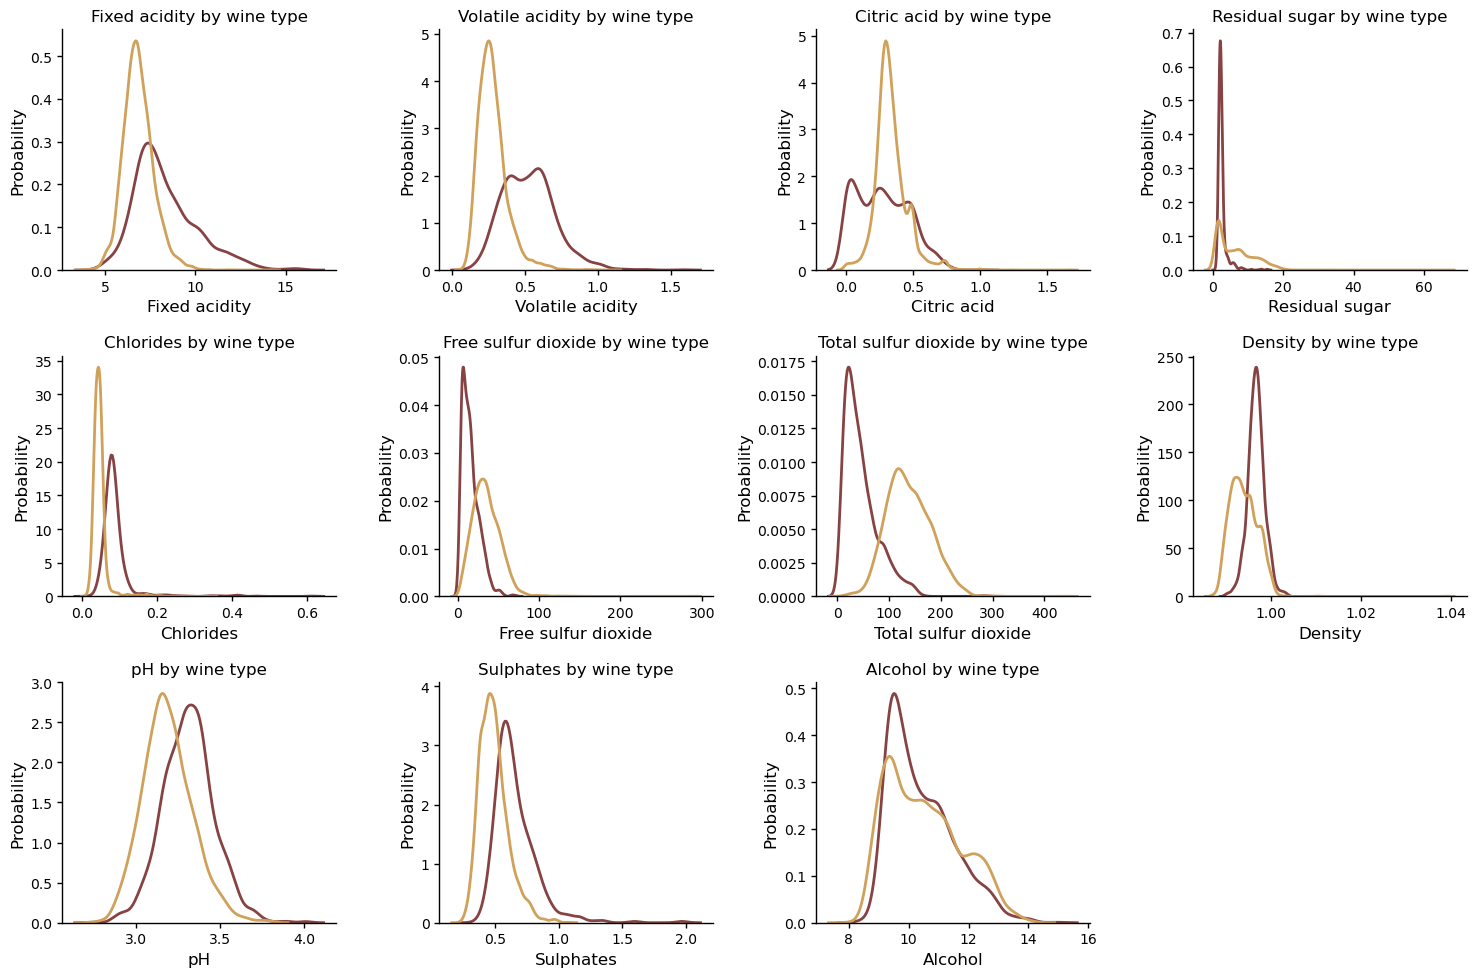

In [11]:
#create a figure with a 4x3 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(plot_size_onerowwidth*3, plot_size_onerowheight*2))
axes = axes.flatten()

#loop and create subplots
for i, column in enumerate(predictors_list):
    ax = axes[i]
    column_label = predictors_labels[i]
    
    #plot density for each wine type
    for wine_type, color in wine_palette_color.items():
        sns.kdeplot(
            data=df_wine[df_wine['wine_type'] == wine_type],
            x=column,
            fill=False,
            common_norm=False,
            color=color,
            linewidth=2,
            label=wine_type,
            ax=ax
        )

    #customize plot
    ax.set_title(f'{column_label} by wine type')
    ax.set_xlabel(column_label)
    ax.set_ylabel('Probability')
    apply_common_settings(ax)

#remove empty subplots if there are any
for j in range(len(predictors_list), len(axes)):
    fig.delaxes(axes[j])

#ensure no overlapping of subplots
plt.tight_layout()

#show figure
plt.show()

Across variables and wine types the distributions seem to be different. Some variables, like pH or sulphates, seem to be more normally distributed, while some others, like alcohol, have clearly fatter tails on one side than on the other. For some variables, like free sulfur dioxide or density, the red wine distribution is sharper, whereas for the variables related to acidity the opposite is true. In general there doesn't seem to be any evidence for clearly multimodal distributions. In terms of overall overlap between the distributions of both with types, some differences are obvious. For instance, we can say that red wines tend to be more dense and higher in pH, acidity and chlorides than white wines, but also lower in sugar and total sulfur dioxide. Because the ultimate goal of this project is not to compare one wine type to the other, we won't conduct any statistical test to confirm those differences.

The variable we'll try to predict is quality, which isn't a continuous but an ordinal, 0-to-10 variable. This makes a density plot less idoneous to visualize it than, for instance, a histogram with as many bins as categories on the scale. So let's try that instead. Because the number of data points for both wine types are different, we'll use percentages instead of counts.

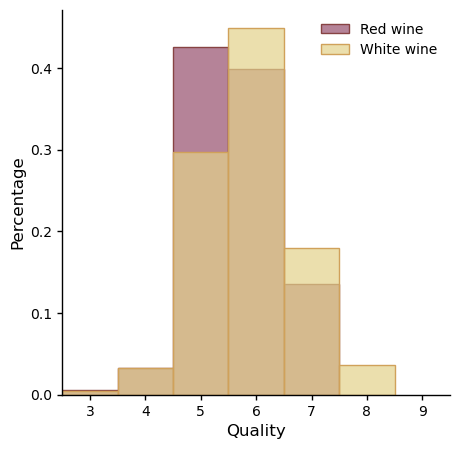

In [12]:
#determine bins and midpoints for figure based on unique quality values
bins_red = sorted(df_red['quality'].unique())
bins_white = sorted(df_white['quality'].unique())
bins_unique = sorted(list(set(bins_red + bins_white)))
bins_midpoints = [i + 0.5 for i in bins_unique]

#create a figure
plt.figure(figsize=(plot_size_onerowwidth, plot_size_onerowheight))

#plot histograms
sns.histplot(df_red['quality'], bins=bins_red, stat='density', color=wine_palette_fill['red'], alpha=0.7, edgecolor=wine_palette_color['red'], label='Red wine')
sns.histplot(df_white['quality'], bins=bins_white, stat='density', color=wine_palette_fill['white'], alpha=0.7, edgecolor=wine_palette_color['white'], label='White wine')

#customize the plot
plt.xlabel('Quality')
plt.ylabel('Percentage')
plt.legend(frameon=False)

#apply custom theme settings
ax = plt.gca()
apply_common_settings(ax)

#set axes ticks, labels and limits
ax.set_xticks(bins_midpoints)
ax.set_xticklabels(bins_unique)
ax.set_xlim( min(bins_midpoints) - 0.5 , max(bins_midpoints) + 0.5)
ax.set_ylim(0, ax.get_ylim()[1])

#show the figure
plt.show()

For both wines we can see that most ratings are towards the middle of the scale, with white wines apparently having slightly better ratings. We can also see that not all values of the scale are used, with ratings on the lower end (0, 1, 2) and the higher end (10) being absent. And while 9 is present on the x-axis, no bar can be appreciated. We can create a DataFrame with the actual percentage of wines assigned to each rating to better know what's going on here.

In [13]:
#calculate percentage values for each wine type
df_percs_quality_red = df_red['quality'].value_counts(normalize=True).sort_index().mul(100).reset_index().rename(columns={'proportion': 'percentage'})
df_percs_quality_white = df_white['quality'].value_counts(normalize=True).sort_index().mul(100).reset_index().rename(columns={'proportion': 'percentage'})

print("Percentage of red wines associated to each rating value:")
display(df_percs_quality_red)
print("Percentage of white wines associated to each rating value:")
display(df_percs_quality_white)

Percentage of red wines associated to each rating value:


,quality,percentage
0,3,0.625391
1,4,3.314572
2,5,42.589118
3,6,39.899937
4,7,12.445278
5,8,1.125704


Percentage of white wines associated to each rating value:


,quality,percentage
0,3,0.408330
1,4,3.327889
2,5,29.746835
3,6,44.875459
4,7,17.966517
5,8,3.572887
6,9,0.102082


The answer is simply that only 0.1% of white wines (and no red wine) were rated with a 9, making the bar almost invisible.

With so many physicochemical predictors, it's reasonable to think that some may be highly correlated. In order to visualize pairwise relationships we can build and visualize a correlation matrix. The code below does that. To avoid duplicity of information we'll create a function to display only the lower diagonal of the matrix. The correlation coefficient, as well as its p-value, will be shown for each pair of variables. The strength of the relationship will also be indicated through a color code.

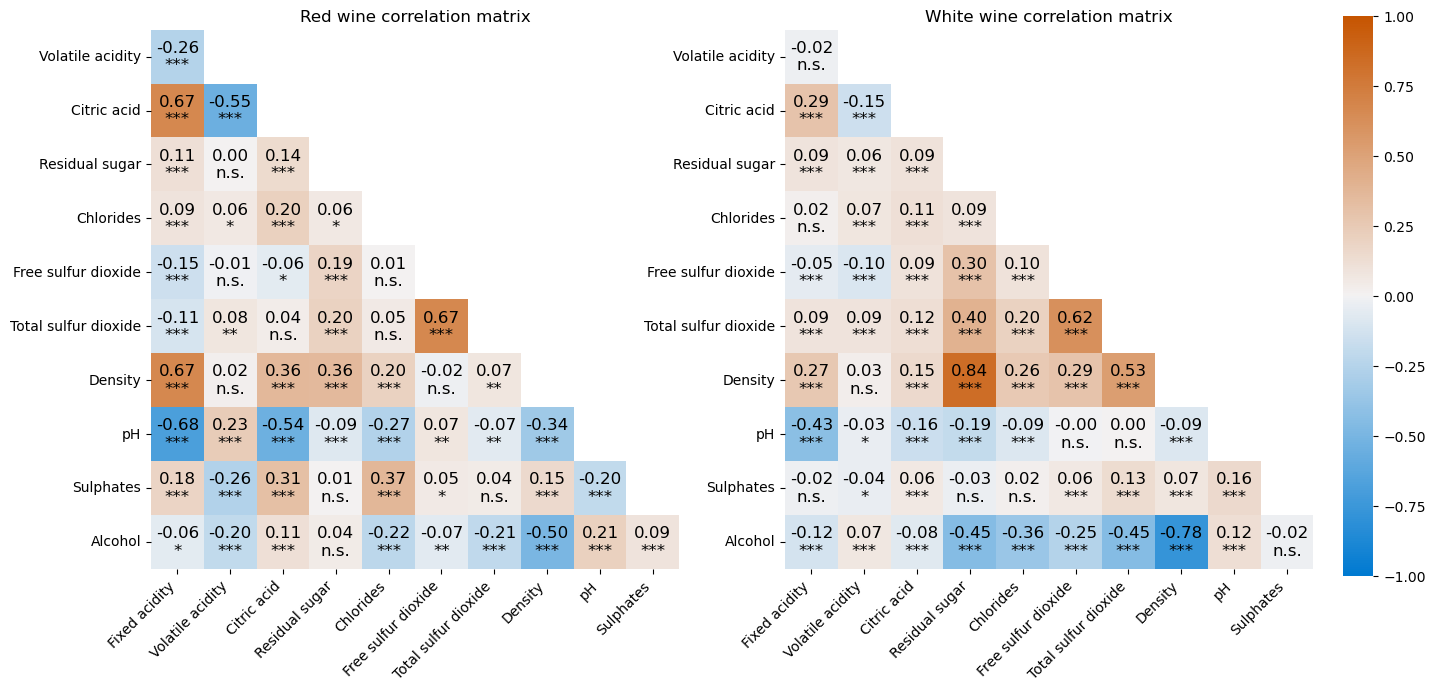

In [14]:
#import necessary function
from scipy.stats import pearsonr

#define function to create lower diagonal correlation matrix with p-values
def create_lower_diagonal_cormatrix(df, columns):
    #initialize empty DataFrames for correlations and p-values
    corr_matrix = pd.DataFrame(index=columns, columns=columns)
    pval_matrix = pd.DataFrame(index=columns, columns=columns)
    
    #compute the correlation coefficients and p-values
    for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = np.nan
                pval_matrix.loc[col1, col2] = np.nan
            elif columns.index(col1) > columns.index(col2):
                corr, pval = pearsonr(df[col1], df[col2])
                corr_matrix.loc[col1, col2] = corr
                pval_matrix.loc[col1, col2] = pval
            else:
                corr_matrix.loc[col1, col2] = np.nan
                pval_matrix.loc[col1, col2] = np.nan
    
    #exclude the bottom row and rightmost column from display
    corr_matrix = corr_matrix.iloc[1:, :-1]
    pval_matrix = pval_matrix.iloc[1:, :-1]
    
    return corr_matrix.astype(float), pval_matrix.astype(float)

#create the correlation matrix for each wine type
red_corr_matrix, red_pval_matrix = create_lower_diagonal_cormatrix(df_red, predictors_list)
white_corr_matrix, white_pval_matrix = create_lower_diagonal_cormatrix(df_white, predictors_list)

#define function to annotate heatmap with both correlation and p-value
def annotate_heatmap(ax, corr_matrix, pval_matrix):
    for y in range(corr_matrix.shape[0]):
        for x in range(corr_matrix.shape[1]):
            if not np.isnan(corr_matrix.iloc[y, x]):
                corr_value = corr_matrix.iloc[y, x]
                p_value = pval_matrix.iloc[y, x]
                
                if p_value > 0.05:
                    pval_annotation = 'n.s.'
                elif p_value >= 0.01:
                    pval_annotation = '*'
                elif p_value >= 0.001:
                    pval_annotation = '**'
                else:
                    pval_annotation = '***'
                
                ax.text(x + 0.5, y + 0.5, 
                        f'{corr_value:.2f}\n{pval_annotation}',
                        ha='center', va='center', fontsize=12, color='black')

#define a colormap
custom_cmap = sns.diverging_palette(h_neg=250, h_pos=25, s=100, l=50, n=9, center="light", as_cmap=True)

#create the figure
fig, axes = plt.subplots(1, 2, figsize=(plot_size_onerowwidth*3, 7))

#create the heatmaps
sns.heatmap(red_corr_matrix, mask=np.isnan(red_corr_matrix), annot=False, cmap=custom_cmap, ax=axes[0],
            cbar=False, vmin=-1, vmax=1) 
axes[0].set_title('Red wine correlation matrix')
annotate_heatmap(axes[0], red_corr_matrix, red_pval_matrix)

sns.heatmap(white_corr_matrix, mask=np.isnan(white_corr_matrix), annot=False, cmap=custom_cmap, ax=axes[1],
            cbar_ax=fig.add_axes([0.92, 0.1, 0.02, 0.8]), vmin=-1, vmax=1)  #manually set color bar position for the second plot
axes[1].set_title('White wine correlation matrix')
annotate_heatmap(axes[1], white_corr_matrix, white_pval_matrix)

#apply custom labels
for ax, corr_matrix in zip(axes, [red_corr_matrix, white_corr_matrix]):
    relevant_columns_x = corr_matrix.columns
    relevant_columns_y = corr_matrix.index
    relevant_labels_x = [label_dict[col] for col in relevant_columns_x]
    relevant_labels_y = [label_dict[col] for col in relevant_columns_y]
    ax.set_xticks(np.arange(len(relevant_labels_x)) + 0.5)
    ax.set_yticks(np.arange(len(relevant_labels_y)) + 0.5)
    ax.set_xticklabels(relevant_labels_x, rotation=45, ha='right')
    ax.set_yticklabels(relevant_labels_y)

#show the figure
plt.show()

Above we can see the correlation matrix for each wine type. The more saturated the orange, the more positive the relationship between a pair of variables are, and more saturated blues denote more negative relationships. The p-value associated to the coefficient is displayed below each correlation coefficient, with this being the code followed:
- n.s.: not significant
- *: 0.05 > p >= 0.01 
- **: 0.01 > p >= 0.001 
- ***: 0.001 > p

We can see how some properties are strongly related to many others. For instance, alcohol holds strong negative relationshis with density, chlorides and total sulfur dioxide. Density has moderate to strong positive relationships with characteristics such as fixed acidity and residual sugar, although the strength highly depends on the type of wine. The differences between wines are obvious, with for instance citric acid holding stronger relationships with other variables in the case of red wine. We don't need our description to be more exhaustive to realize that, indeed, many of these variables are significantly related. This will likely lead to high colinearity, making our model fitting slightly problematic. But we'll worry about this later. Now that we know the data a bit better, it's time to start the machine learning part.

## 5. Model training, evaluation and comparison
We've reached the main part of the project. In this section we'll put forward a series of models and see how well they can predict wine quality on the basis of the different physicochemical properties. 

We'll use a unified approach for model training and evaluation. First, we'll split the data between a training set and a test set. For those models that apply, we'll use grid search to define which hyperparameters, and which values within each hyperparameter, we want to explore. A model with each unique combination of parameter values will be trained on the training set via cross-validation, where we'll split the training data in 5 folds and do the training as many times, each time with a different fold being used as validation set and the others as training set. Then the MAE over the validation sets will be averaged. Once this has been done for all models, we'll choose the model whose combination of hyperparameters maximizes MAE (or, technically, that minimizes negative MAE). This combination of hyperparameters will be extracted and used to retrain the model, but instead of using cross-validation, the model will be trained on the whole training data. We then will generate predictions for the test data and evaluate performance by comparing those predicted quality ratings to the actual ratings through a series of performance metrics. Finally, we'll use those performance metrics to compare different models.

### 5.1. Splitting data into training and testing sets
One of the most basic practices of machine learning is to train and test the model with different portions of the dataset. The first step then is to perform such dataset split. Since we'll make that split andomly with a function from Scikit-learn, our results could slightly differ every time we run the analyses. To make our project reproducible we'll define a random state that will make the split (and other forthcoming procedures) always the same. When splitting the data, we'll assign 80% of the dataset to the train set and 20% to the test set.

In [15]:
#import necessary function
from sklearn.model_selection import train_test_split

#defining random state to make our analyses reproducible
ranstate = 42

#split datasets into training and testing sets
X_red = df_red[predictors_list]
y_red = df_red['quality']
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.2, random_state=ranstate)

X_white = df_white[predictors_list]
y_white = df_white['quality']
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white, y_white, test_size=0.2, random_state=ranstate)


### 5.2. Creating a model evaluation function
Next we have to think which of the different available metrics we'll use to assess the performance of a model. One of the most common ones is Mean Absolute Error (MAE), which is the average of the absolute differences between predicted values and actual values. Another one is Mean Squared Error (MSE), which is the average of the squared differences between predicted values and actual values. MAE is less sensitive to outliers, but MSE is sometimes preferred when working with linear regression. Related to this, Root Mean Squared Error (RMSE) is also less sensitive to outliers, but its output is given in units of the dependent variable, which in our case is quality ratings. Finally, one of the quintessential metrics associated to linear models is r<sup>2</sup>,  the proportion of the variance in the dependent variable that is predictable from the independent variables. However, such metric assumes a linear relationship between dependent and independent variables.

We'll take MAE as our statistic of reference when assessing performance within our cross-validation and grid search approach. However, we'll display the four aforementioned metrics for each of those models we retrain with the winning parameters. While MAE will be useful to compare linear and non-linear models, the other three will be useful to arbitrate among the different linear models we'll test. We'll now create a function that calculates these indicators from the true and predicted data for each model. Information on each model's indicators will be appended to a DataFrame that will make comparison easy.

In [16]:
#import necessary functions
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#define function to calculate performance metrics
def evaluate_model_to_df(y_true, y_pred, model_name, existing_df=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    #create a DataFrame with the performance metrics
    data = {
        'model': [model_name],
        'MSE': [mse],
        'RMSE': [rmse],
        'MAE': [mae],
        'R2': [r2]
    }
    
    df = pd.DataFrame(data)
    
    #if an existing DataFrame is provided and not empty, concatenate the new results
    if existing_df is not None and not existing_df.empty:
        df = pd.concat([existing_df, df], ignore_index=True)
    
    return df

#initialize an empty DataFrame
performance_df_red = pd.DataFrame(columns=['model', 'MSE', 'RMSE', 'MAE', 'R2'])
performance_df_white = pd.DataFrame(columns=['model', 'MSE', 'RMSE', 'MAE', 'R2'])

### 5.3. Comparing linear regression to random forest
We can finally start training models and evaluate the quality of their predictions. Two of the most used groups of models are linear models and tree models. Within those families, two obvious choices to start are linear regression and random forest. As said above, linear regression tries to model a linear relationship between a series of predictors and the dependent variable. Although it has some assumptions, it's one of the most commonly used models. A random forest model is an ensemble of decision trees that are performed at the same time. While it's more difficult to interpret what's happening under the hood, it's very popular due to its robustness and the fact that it can easily model non-linear relationships. Thus, these two models are a good start, and should give us some intuition on whether the nature of the relationship to study is highly linear or not.

An important issue here is that we're trying to predict 0-to-10 scalar data, yet out of the box these models will give us continuous predictions. While there are other ways to handle this, we'll take the simplest approach, which is to round the prediction to the nearest integer.

We'll start by training a linear regression model. As opposed to the rest of the models we'll use, linear regression doesn't have any hyperparameter to tune. Thus, we'll simply use cross-validation to train the model, print the cross-validation MAE, generate predictions with the only model we trained, and evaluate its performance by adding our chosen metrics to a performance DataFrame.

In [17]:
#load necessary functions
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

#red wine data, standardize train and test data
scaler = StandardScaler()
X_train_red_scaled = scaler.fit_transform(X_train_red)
X_test_red_scaled = scaler.transform(X_test_red)

#red wine data, linear regression: cross-validate and evaluate
lr_red = LinearRegression() #define type of model to train
cv_scores_red = cross_val_score(lr_red, X_train_red_scaled, y_train_red, cv=5, scoring='neg_mean_absolute_error') #cross-validation on training data
mean_cv_score_red = -cv_scores_red.mean()
print(f"red wine data, linear regression cross-validation MAE: {mean_cv_score_red:.4f}")

#red wine data, linear regression: fit model on entire training data and predict on test set
lr_red.fit(X_train_red_scaled, y_train_red)
y_pred_red_lr = lr_red.predict(X_test_red_scaled)
y_pred_red_lr = y_pred_red_lr.round()

test_mae_red = mean_absolute_error(y_test_red, y_pred_red_lr)
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_red_lr, 'Linear Regression', performance_df_red)

#red wine data, display the performance DataFrame
print("red wine data, model performance comparison:")
display(performance_df_red)

#white wine data, standardize train and test data
X_train_white_scaled = scaler.fit_transform(X_train_white)
X_test_white_scaled = scaler.transform(X_test_white)

#white wine data, linear regression: cross-validate and evaluate
lr_white = LinearRegression() #define type of model to train
cv_scores_white = cross_val_score(lr_white, X_train_white_scaled, y_train_white, cv=5, scoring='neg_mean_absolute_error') #cross-validation on training data
mean_cv_score_white = -cv_scores_white.mean()
print(f"white wine data, linear regression cross-validation MAE: {mean_cv_score_white:.4f}")

#white wine data, linear regression: fit model on entire training data and predict on test set
lr_white.fit(X_train_white_scaled, y_train_white)
y_pred_white_lr = lr_white.predict(X_test_white_scaled)
y_pred_white_lr = y_pred_white_lr.round()

test_mae_white = mean_absolute_error(y_test_white, y_pred_white_lr)
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_white_lr, 'Linear Regression', performance_df_white)

#white wine data, display the performance DataFrame
print("white wine data, model performance comparison:")
display(performance_df_white)

red wine data, linear regression cross-validation MAE: 0.5072
red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.45625,0.675463,0.4375,0.301843


white wine data, linear regression cross-validation MAE: 0.5847
white wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909


The MAE statistic is in units of the dependent variable: that is, quality ratings. That means that, for the red wine data, rating predictions from the final model deviate on average 0.44 points from the true value, whereas for the white wine data the average error is higher, 0.54. When focusing on r<sup>2</sup>, we see it's not very high, and in the case of the white wine data even very low, with predictors only accounting for 14% of the variability in the data. A problem leading to that may be the colinearity of the different predictors.

Now let's train and evaluate a random forest model for each dataset. From now on we'll stick to the procedure outlined at the start of the section: parameter tuning with grid search and individual model fit via cross-validation, selection of the model whose parameter combination minimizes MAE, retraining the winning model with the whole training data, predictions generation on the test set, evaluation of such predictions with our performance metrics, and inclusion of those metrics in our performance DataFrames that will facilitate model comparison.

When defining the grid search we have to consider the hyperparameters to tune. In the case of the random forest models, we'll explore different values of 6 different basic parameters, whose range of tested values will reflect common practice. 

`n_estimators`: the number of decision trees that form the random forest. We'll explore 100, 200 and 300.

`max_features`: the number of features to consider when looking for the best split. We'll explore all features (None), the square root of all features (sqrt) and the log2 of all features (log2).
 
 `max_depth`: the maximum depth of the tree. We'll explore 10, 20, 30 and no specified depth.
 
 `min_samples_split`: the minimum number of samples required to split an internal node. We'll explore 2, 5 and 10 samples.
 
 `min_samples_leaf`: the minimum samples required to be at a leaf node. We'll explore 1, 2 and 4 samples.
 
 `bootstrap`: whether the whole dataset is used to build the whole tree (False) or bootstrap samples are used instead (True). We'll explore both.

Since running the whole thing may take a while, the current project will just load two files containing the whole grid search data for each wine type, previously run and saved. For completion, the next chunk contains the code to conduct the process and save the files. This can be done by uncommenting the first line of the chunk below.

In [18]:
%%script false --no-raise-error #comment if wanting to run this chunk

#import necessary libraries
from sklearn.ensemble import RandomForestRegressor
import joblib

#define the parameter grid for random forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#red wine data, run grid search for random forest, get best parameters and retrain on whole train set
rfopt_red = RandomForestRegressor(random_state=ranstate) #define model type
grid_search_red = GridSearchCV(
    estimator=rfopt_red, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    scoring='neg_mean_absolute_error'
)

grid_search_red.fit(X_train_red, y_train_red) #run grid search
best_params_red = grid_search_red.best_params_ #get best parameters
best_rf_red = RandomForestRegressor(**best_params_red, random_state=ranstate) #define new model with best parameters
best_rf_red.fit(X_train_red, y_train_red) #retrain best model on entire training set
joblib.dump(best_rf_red, 'best_rf_red.pkl') #save the retrained model

#white wine data, run grid search for random forest, get best parameters and retrain on whole train set
rfopt_white = RandomForestRegressor(random_state=ranstate) #define model type
grid_search_white = GridSearchCV(
    estimator=rfopt_white, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    scoring='neg_mean_absolute_error'
)

grid_search_white.fit(X_train_white, y_train_white) #run grid search
best_params_white = grid_search_white.best_params_ #get best parameters
best_rf_white = RandomForestRegressor(**best_params_white, random_state=ranstate) #define new model with best parameters
best_rf_white.fit(X_train_white, y_train_white) #retrain best model on entire training set
joblib.dump(best_rf_white, 'best_rf_white.pkl') #save the retrained model

We can retrieve and print the parameter values of the winning models.

In [19]:
#import necessary library
import joblib

#load best models
best_rf_red = joblib.load('best_rf_red.pkl')
best_rf_white = joblib.load('best_rf_white.pkl')

#create a list of all parameters we explored
explored_params_rf = ['n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap']

#red wine data, get parameters of best random forest model and print them
rf_params_red = best_rf_red.get_params()
print("Red wine data, best random forest model parameters:")
for param, value in rf_params_red.items():
    if param in explored_params_rf:
        print(f"{param}: {value}")

#white wine data, get parameters of best random forest model and print them
rf_params_white = best_rf_white.get_params()
print("White wine data, best random forest model parameters:")
for param, value in rf_params_white.items():
    if param in explored_params_rf:
        print(f"{param}: {value}")

Red wine data, best random forest model parameters:
bootstrap: False
max_depth: 30
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 300
White wine data, best random forest model parameters:
bootstrap: False
max_depth: 30
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 300


For both wine types the best model has the same parameter values. Now we'll load the fit of the retrained models with those best parameters and evaluate their performance.

In [20]:
#red wine data: predict and evaluate best model on the test set
y_pred_rf_red = best_rf_red.predict(X_test_red)
y_pred_rf_red = y_pred_rf_red.round()
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_rf_red, 'Random Forest', performance_df_red)

#red wine data, display the performance DataFrame
print("Red wine data, model performance comparison:")
display(performance_df_red)

#white wine data: predict and evaluate best model on the test set
y_pred_rf_white = best_rf_white.predict(X_test_white)
y_pred_rf_white = y_pred_rf_white.round()
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_rf_white, 'Random Forest', performance_df_white)

#white wine data, display the performance DataFrame
print("White wine data, model performance comparison:")
display(performance_df_white)

Red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.45625,0.675463,0.4375,0.301843
1,Random Forest,0.35000,0.591608,0.3375,0.464427


White wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909
1,Random Forest,0.375510,0.612789,0.314286,0.515141


For each wine type, we now have the performance metrics for both linear regression and random forest. Since we're comparing a linear and a non-linear model we'll use the MAE as our measure of reference. For both wine types, the MAE is lower for the random forest model than for the linear regression model, indicating better predictions. Interestingly, as opposed to with the linear regression, for the random forest predictions are better for the white wine data than for the red wine data. This may give us a hint that the relationship between predictors and quality may be more linear in the case of the red wine dataset.

### 5.4. Checking for colinearity and refitting the models after dimensionality reduction
Earlier we've seen that the physicochemical properties we use as predictors are correlated to different extents. Such correlation could be affecting the linear regression we performed. While the correlation matrix helped us see pairwise correlations between variables, there is a measure that indexes the degree of multicolinearity, or how correlated a variable is with all other variables in general. This measure is called variance inflation factor (VIF). As a rule of thumb, variables with a VIF over 10 are affected by high multicolinearity. Let's calculate the VIF for each predictor and wine type.

In [21]:
#import necessary functions
from statsmodels.stats.outliers_influence import variance_inflation_factor

#define function to calculate VIF for each predictor
def calculate_vif(df, predictors):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = predictors
    vif_data['VIF'] = [variance_inflation_factor(df[predictors].values, i) for i in range(len(predictors))]
    return vif_data

#calculate VIF for red wine predictors
vif_red = calculate_vif(df_red, predictors_list)
print("Predictor VIF for red wine data:")
print(vif_red)

#calculate VIF for white wine predictors
vif_white = calculate_vif(df_white, predictors_list)
print("Predictor VIF for white wine data:")
print(vif_white)

Predictor VIF for red wine data:
                 Feature          VIF
0          fixed_acidity    74.452265
1       volatile_acidity    17.060026
2            citric_acid     9.183495
3         residual_sugar     4.662992
4              chlorides     6.554877
5    free_sulfur_dioxide     6.442682
6   total_sulfur_dioxide     6.519699
7                density  1479.287209
8                     ph  1070.967685
9              sulphates    21.590621
10               alcohol   124.394866
Predictor VIF for white wine data:
                 Feature          VIF
0          fixed_acidity    92.861483
1       volatile_acidity     9.730569
2            citric_acid    10.007114
3         residual_sugar     3.830272
4              chlorides     6.497448
5    free_sulfur_dioxide     9.261556
6   total_sulfur_dioxide    24.980802
7                density  1056.497431
8                     ph   609.861725
9              sulphates    20.527123
10               alcohol   118.707368


A lot of those variables have a very large VIF. Reassuringly, we can see that VIF magnitude for a predictor is related to the value of the correlation coefficients in the correlation matrices we visualized earlier. For instance, residual sugar, which has the lowest VIF for both wine types, has also very low, often non-significant correlation coefficients with the other predictors, illustrated by the very pale, almost white colors in the respective correlation matrices' cells.

Something we could do to deal with multicolinearity is reducing the number of predictors. While a way to do that is to remove variables, another approach is to use Principal Component Analysis (PCA). This would allow us to combine our original predictors in a reduced number of principal components, each of which explaining an independent portion of the variance in the data. As an exhausitve approach, let's iteratively reduce our predictors to a number of principal components ranging from 1 to 11, which is the original number of predictors. For each number of principal components, let's see the proporion of variance in the data they explain. Then, let's train a linear regression and a random forest models to such reduced data, and calculate the performance indicators we're already familiar with. For the random forest models, though, parameter tuning for each number of components would be very resource and time consuming. Thus, we'll use its out-of-the-box version, leaving all hyperparameter values to their default.

In [22]:
#import necessary functions
from sklearn.decomposition import PCA

#standardize the predictors
X_red_scaled = scaler.fit_transform(df_red[predictors_list])
X_white_scaled = scaler.fit_transform(df_white[predictors_list])

#define function to evaluate model and return metrics as a dictionary
def evaluate_model_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mse, rmse, mae, r2

#initialize lists to store results (working with lists to avoid Pandas warnings when appending data to empty DataFrames)
results_red_list = []
results_white_list = []

#iterate over the number of components from 1 to 11
for n_components in range(1, 12):
    
    #red wine data, apply PCA and calculate explained variance
    pca_red = PCA(n_components=n_components)  #apply PCA with n_components
    X_red_pca = pca_red.fit_transform(X_red_scaled)
    explained_variance_red = np.sum(pca_red.explained_variance_ratio_) #calculate explained variance

    #red wine data, split data into train and test sets
    X_train_red_pca, X_test_red_pca, y_train_red, y_test_red = train_test_split(X_red_pca, df_red['quality'], test_size=0.2, random_state=ranstate)
    
    #red wine data, fit models, make predictions and evaluate performance
    lr_red_pca = LinearRegression()
    rf_red_pca = RandomForestRegressor(random_state=ranstate)
    lr_red_pca.fit(X_train_red_pca, y_train_red) #fit linear regression model
    rf_red_pca.fit(X_train_red_pca, y_train_red) #fit random forest model
    y_pred_lr_red_pca = lr_red_pca.predict(X_test_red_pca).round() #make predictions, linear regression
    y_pred_rf_red_pca = rf_red_pca.predict(X_test_red_pca).round() #make predictions, random forest
    mse_lr_red, rmse_lr_red, mae_lr_red, r2_lr_red = evaluate_model_metrics(y_test_red, y_pred_lr_red_pca) #collect metrics, linear regression
    mse_rf_red, rmse_rf_red, mae_rf_red, r2_rf_red = evaluate_model_metrics(y_test_red, y_pred_rf_red_pca) #collect metrics, random forest

    #red wine data, append metrics to the results lists
    results_red_list.append({
        'n_components': n_components,
        'explained_variance': explained_variance_red,
        'MSE_lr': mse_lr_red, 'RMSE_lr': rmse_lr_red, 'MAE_lr': mae_lr_red, 'R2_lr': r2_lr_red,
        'MSE_rf': mse_rf_red, 'RMSE_rf': rmse_rf_red, 'MAE_rf': mae_rf_red, 'R2_rf': r2_rf_red
    })

    #white wine data, apply PCA and calculate explained variance
    pca_white = PCA(n_components=n_components)  
    X_white_pca = pca_white.fit_transform(X_white_scaled)
    explained_variance_white = np.sum(pca_white.explained_variance_ratio_)
    
    #white wine data, split data into train and test sets
    X_train_white_pca, X_test_white_pca, y_train_white, y_test_white = train_test_split(X_white_pca, df_white['quality'], test_size=0.2, random_state=ranstate)
    
    #white wine data, fit models, make predictions and evaluate performance
    lr_white_pca = LinearRegression()
    rf_white_pca = RandomForestRegressor(random_state=ranstate)
    lr_white_pca.fit(X_train_white_pca, y_train_white)
    rf_white_pca.fit(X_train_white_pca, y_train_white)
    y_pred_lr_white_pca = lr_white_pca.predict(X_test_white_pca).round()
    y_pred_rf_white_pca = rf_white_pca.predict(X_test_white_pca).round()
    mse_lr_white, rmse_lr_white, mae_lr_white, r2_lr_white = evaluate_model_metrics(y_test_white, y_pred_lr_white_pca)
    mse_rf_white, rmse_rf_white, mae_rf_white, r2_rf_white = evaluate_model_metrics(y_test_white, y_pred_rf_white_pca)
    
    #white wine data, append metrics to the results lists
    results_white_list.append({
        'n_components': n_components,
        'explained_variance': explained_variance_white,
        'MSE_lr': mse_lr_white, 'RMSE_lr': rmse_lr_white, 'MAE_lr': mae_lr_white, 'R2_lr': r2_lr_white,
        'MSE_rf': mse_rf_white, 'RMSE_rf': rmse_rf_white, 'MAE_rf': mae_rf_white, 'R2_rf': r2_rf_white
    })

#red wine data, convert results list to DataFrame
pca_modelperformance_red = pd.DataFrame(results_red_list)

#red wine data, display the results DataFrame
print("Red wine model performance with different primcipal components:")
display(pca_modelperformance_red)

#white wine data, convert results list to DataFrame
pca_modelperformance_white = pd.DataFrame(results_white_list)

#white wine data, display the results DataFrame
print("White wine model performance with different primcipal components:")
display(pca_modelperformance_white)

Red wine model performance with different primcipal components:


,n_components,explained_variance,MSE_lr,RMSE_lr,MAE_lr,R2_lr,MSE_rf,RMSE_rf,MAE_rf,R2_rf
0,1,0.281739,0.796875,0.892679,0.653125,-0.219385,1.009375,1.004677,0.684375,-0.544554
1,2,0.456822,0.662500,0.813941,0.537500,-0.013763,0.628125,0.792543,0.503125,0.038838
2,3,0.597781,0.506250,0.711512,0.475000,0.225332,0.481250,0.693722,0.425000,0.263587
3,4,0.708074,0.506250,0.711512,0.475000,0.225332,0.390625,0.625000,0.365625,0.402262
4,5,0.795283,0.465625,0.682367,0.446875,0.287497,0.412500,0.642262,0.375000,0.368789
5,6,0.855247,0.468750,0.684653,0.450000,0.282715,0.403125,0.634921,0.371875,0.383135
6,7,0.908319,0.478125,0.691466,0.453125,0.268369,0.359375,0.599479,0.328125,0.450081
7,8,0.946770,0.446875,0.668487,0.428125,0.316188,0.396875,0.629980,0.353125,0.392699
8,9,0.978101,0.446875,0.668487,0.428125,0.316188,0.368750,0.607248,0.343750,0.435736
9,10,0.994586,0.446875,0.668487,0.428125,0.316188,0.350000,0.591608,0.325000,0.464427


White wine model performance with different primcipal components:


,n_components,explained_variance,MSE_lr,RMSE_lr,MAE_lr,R2_lr,MSE_rf,RMSE_rf,MAE_rf,R2_rf
0,1,0.292932,0.783673,0.885253,0.626531,-0.011879,0.863265,0.929121,0.597959,-0.114648
1,2,0.436136,0.809184,0.899546,0.637755,-0.044818,0.614286,0.783764,0.481633,0.206834
2,3,0.547197,0.781633,0.884100,0.618367,-0.009244,0.544898,0.738172,0.446939,0.296428
3,4,0.639790,0.777551,0.881789,0.612245,-0.003974,0.459184,0.677631,0.391837,0.407102
4,5,0.728275,0.777551,0.881789,0.608163,-0.003974,0.451020,0.671581,0.381633,0.417642
5,6,0.813615,0.777551,0.881789,0.610204,-0.003974,0.437755,0.661631,0.370408,0.434770
6,7,0.879669,0.774490,0.880051,0.607143,-0.000022,0.444898,0.667007,0.373469,0.425548
7,8,0.934156,0.720408,0.848769,0.579592,0.069809,0.419388,0.647602,0.356122,0.458486
8,9,0.971806,0.680612,0.824992,0.543878,0.121193,0.433673,0.658539,0.368367,0.440041
9,10,0.998123,0.662245,0.813784,0.547959,0.144909,0.422449,0.649961,0.353061,0.454534


Quite a lot to unpack here. First, we can see how, for both wine types, most explained variance cannot be accounted by a very reduced number of principal components. Moreover, if we take a look at the `R2_lr`column, the r<sup>2</sup> does not benefit from dimensionality reduction. MAE doesn't either for none of the two models, as evidenced by the values in `MAE_lr`and `MAE_rf`. Given such results, it may be better to stick to the original number of predictors, numerous as they may be. Otherwise we'd be encountering potential interpretability issues, like grasping what each principal component is capturing, with no better model fit in exchange. Let's explore other ways to deal with our many, correlated predictors.

##### 5.5. Testing ridge regression and lasso regression
Ridge regression and lasso regression are two slightly different methods to handle multicollinearity by penalizing some coefficients. Ridge regression keeps all predictors but reduces some predictors' coefficients, with the penalty being proportional to the sum of the squares of the coefficients (L2 regularization). On the other hand, lasso regression applies a penalty proportional to the sum of the absolute values of the coefficients (L1 regularization), which sometimes leads to setting some coefficients to zero, a way to apply feature selection.

Here we'll follow a similar approach as with the random forest and train ridge regression and lasso regression models on our data so then we can evaluate the performance of their predictive power. As opposed to the many parameters we tuned before, though, in these models the only parameter to control is alpha. In ridge and lasso regressions, such parameter controls the strength of L2 and L1 regularization, respectively. An alpha of 0 is equivalent to ordinary least squares regression, whereas bigger values of alpha will penalize coefficients more. We'll choose a few values of alpha ranging from light to heavy regularization. We'll start with ridge regression.

In [23]:
#import necessary function
from sklearn.linear_model import Ridge

#define the parameter grid for Ridge regression and initialize scaler and estimator
param_grid = {'alpha': [0.01, 0.1, 0.2, 0.5, 1.0, 2, 5, 10, 25, 50, 100, 200.0]}
ridge = Ridge()

#red wine data, set up grid search
grid_search_red = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_red.fit(X_train_red_scaled, y_train_red)

#red wine data, print performance metrics for each alpha and retrain best model with best alpha
cv_results_red = grid_search_red.cv_results_
for mean_score, params in zip(cv_results_red['mean_test_score'], cv_results_red['params']):
    print(f"Alpha: {params['alpha']}, MAE: {-mean_score}")
best_alpha_red = grid_search_red.best_params_['alpha']
best_ridge_red = Ridge(alpha=best_alpha_red)
best_ridge_red.fit(X_train_red_scaled, y_train_red)

#red wine data, predict and evaluate on test set
y_pred_ridge_red = best_ridge_red.predict(X_test_red_scaled)
y_pred_ridge_red = y_pred_ridge_red.round()
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_ridge_red, f'Ridge Regression (alpha={best_alpha_red})', performance_df_red)

#red wine data, display the performance DataFrame
print("red wine data, model performance comparison:")
display(performance_df_red)

#white wine data, set up grid search
grid_search_white = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_white.fit(X_train_white_scaled, y_train_white)

#white wine data, print performance metrics for each alpha and retrain best model with best alpha
cv_results_white = grid_search_white.cv_results_
for mean_score, params in zip(cv_results_white['mean_test_score'], cv_results_white['params']):
    print(f"Alpha: {params['alpha']}, MAE: {-mean_score}")
best_alpha_white = grid_search_white.best_params_['alpha']
best_ridge_white = Ridge(alpha=best_alpha_white)
best_ridge_white.fit(X_train_white_scaled, y_train_white)

#white wine data, predict and evaluate on test set
y_pred_ridge_white = best_ridge_white.predict(X_test_white_scaled)
y_pred_ridge_white = y_pred_ridge_white.round()
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_ridge_white, f'Ridge Regression (alpha={best_alpha_white})', performance_df_white)

#red wine data, display the performance DataFrame
print("White wine data, model performance comparison:")
display(performance_df_white)

Alpha: 0.01, MAE: 0.5071721727469464
Alpha: 0.1, MAE: 0.5071718096646726
Alpha: 0.2, MAE: 0.5071714105533859
Alpha: 0.5, MAE: 0.5071702402655761
Alpha: 1.0, MAE: 0.5071683787518484
Alpha: 2, MAE: 0.5071649806882832
Alpha: 5, MAE: 0.5071619570487961
Alpha: 10, MAE: 0.507177789277987
Alpha: 25, MAE: 0.5073402613652496
Alpha: 50, MAE: 0.5078208214904503
Alpha: 100, MAE: 0.5090782296208971
Alpha: 200.0, MAE: 0.5127617913109301
red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.45625,0.675463,0.4375,0.301843
1,Random Forest,0.35000,0.591608,0.3375,0.464427
2,Ridge Regression (alpha=5),0.45625,0.675463,0.4375,0.301843


Alpha: 0.01, MAE: 0.5846874972569089
Alpha: 0.1, MAE: 0.5846871050518978
Alpha: 0.2, MAE: 0.5846866719363545
Alpha: 0.5, MAE: 0.5846853892279966
Alpha: 1.0, MAE: 0.5846833055799034
Alpha: 2, MAE: 0.5846793477096388
Alpha: 5, MAE: 0.5846703482329826
Alpha: 10, MAE: 0.5846614264247273
Alpha: 25, MAE: 0.5847114672518992
Alpha: 50, MAE: 0.5848738041960174
Alpha: 100, MAE: 0.5852327231600455
Alpha: 200.0, MAE: 0.5860314384648232
White wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909
1,Random Forest,0.375510,0.612789,0.314286,0.515141
2,Ridge Regression (alpha=10),0.662245,0.813784,0.541837,0.144909


We can see that, for both wine type data, MAE values do not change much across alpha values, and that the retrained, final model has the exacte same performance statistics as the linear regression. This could be due to the fact that our predictions are rounded up before evaluating their performance. To check if that's true, let's just evaluate modern performance of both the best linear regression and ridge regression models by using non-rounded predictions.

In [24]:
y_pred_red_lr_noround = lr_red.predict(X_test_red_scaled)
y_pred_ridge_red_noround = best_ridge_red.predict(X_test_red_scaled)

print("Red wine data, best model for linear regression, non-rounded predictions performance indicators: MSE, RMSE, MAE, R2:")
display(evaluate_model_metrics(y_test_red, y_pred_red_lr_noround))

print("Red wine data, best model for ridge regression, non-rounded predictions performance indicators: MSE, RMSE, MAE, R2:")
display(evaluate_model_metrics(y_test_red, y_pred_ridge_red_noround))

Red wine data, best model for linear regression, non-rounded predictions performance indicators: MSE, RMSE, MAE, R2:


(0.3900251439639551,
 0.6245199307980132,
 0.5035304415524375,
 0.40318034127962166)

Red wine data, best model for ridge regression, non-rounded predictions performance indicators: MSE, RMSE, MAE, R2:


(0.3900948592145369,
 0.6245757433766835,
 0.5036762553637696,
 0.4030736624341581)

Indeed, performance evaluation made from unrounded predictions differ between both models. This means that both models made very similar predictions, would became exactly the same with the rounding. We'll now follow the training, model selection and evaluation procedure with lasso regression. 

In [25]:
#import necessary function
from sklearn.linear_model import Lasso

#define the parameter grid for Lasso regression and initialize scaler and estimator
param_grid = {'alpha': [0.01, 0.1, 0.2, 0.5, 1.0, 2, 5, 10, 25, 50, 100, 200.0]}
lasso = Lasso(max_iter=10000)  #define lasso model with number of iterations

#red wine data, set up grid search
grid_search_red = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_red.fit(X_train_red_scaled, y_train_red)

#red wine data, print performance metrics for each alpha and retrain best model with best alpha
cv_results_red = grid_search_red.cv_results_
for mean_score, params in zip(cv_results_red['mean_test_score'], cv_results_red['params']):
    print(f"Alpha: {params['alpha']}, MAE: {-mean_score}")
best_alpha_red = grid_search_red.best_params_['alpha']
best_lasso_red = Lasso(alpha=best_alpha_red, max_iter=10000)  #fit the best lasso model with number of iterations
best_lasso_red.fit(X_train_red_scaled, y_train_red)

#red wine data, predict and evaluate on test set
y_pred_lasso_red = best_lasso_red.predict(X_test_red_scaled)
y_pred_lasso_red = y_pred_lasso_red.round()
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_lasso_red, f'Lasso Regression (alpha={best_alpha_red})', performance_df_red)

#red wine data, display the performance DataFrame
print("red wine data, model performance comparison:")
display(performance_df_red)

#white wine data, set up grid search
grid_search_white = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_white.fit(X_train_white_scaled, y_train_white)

#white wine data, print performance metrics for each alpha and retrain best model with best alpha
cv_results_white = grid_search_white.cv_results_
for mean_score, params in zip(cv_results_white['mean_test_score'], cv_results_white['params']):
    print(f"Alpha: {params['alpha']}, MAE: {-mean_score}")
best_alpha_white = grid_search_white.best_params_['alpha']
best_lasso_white = Lasso(alpha=best_alpha_white, max_iter=10000)
best_lasso_white.fit(X_train_white_scaled, y_train_white)

#white wine data, predict and evaluate on test set
y_pred_lasso_white = best_lasso_white.predict(X_test_white_scaled)
y_pred_lasso_white = y_pred_lasso_white.round()
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_lasso_white, f'Lasso Regression (alpha={best_alpha_white})', performance_df_white)

#white wine data, display the performance DataFrame
print("white wine data, model performance comparison:")
display(performance_df_white)

Alpha: 0.01, MAE: 0.5087356528414885
Alpha: 0.1, MAE: 0.5461062966928899
Alpha: 0.2, MAE: 0.5943983773996444
Alpha: 0.5, MAE: 0.6848510364556379
Alpha: 1.0, MAE: 0.6848510364556379
Alpha: 2, MAE: 0.6848510364556379
Alpha: 5, MAE: 0.6848510364556379
Alpha: 10, MAE: 0.6848510364556379
Alpha: 25, MAE: 0.6848510364556379
Alpha: 50, MAE: 0.6848510364556379
Alpha: 100, MAE: 0.6848510364556379
Alpha: 200.0, MAE: 0.6848510364556379
red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.45625,0.675463,0.4375,0.301843
1,Random Forest,0.35000,0.591608,0.3375,0.464427
2,Ridge Regression (alpha=5),0.45625,0.675463,0.4375,0.301843
3,Lasso Regression (alpha=0.01),0.46875,0.684653,0.4500,0.282715


Alpha: 0.01, MAE: 0.5869197918569637
Alpha: 0.1, MAE: 0.6119836145588902
Alpha: 0.2, MAE: 0.6327510839818545
Alpha: 0.5, MAE: 0.6727520123130994
Alpha: 1.0, MAE: 0.6727520123130994
Alpha: 2, MAE: 0.6727520123130994
Alpha: 5, MAE: 0.6727520123130994
Alpha: 10, MAE: 0.6727520123130994
Alpha: 25, MAE: 0.6727520123130994
Alpha: 50, MAE: 0.6727520123130994
Alpha: 100, MAE: 0.6727520123130994
Alpha: 200.0, MAE: 0.6727520123130994
white wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909
1,Random Forest,0.375510,0.612789,0.314286,0.515141
2,Ridge Regression (alpha=10),0.662245,0.813784,0.541837,0.144909
3,Lasso Regression (alpha=0.01),0.653061,0.808122,0.538776,0.156767


For both wine types the best alpha is 0.01, corresponding to the softest regularization. When comparing ridge regression to lasso regression their performance depends on the metric we use, but none of the newly introduced models perform better the random forest.

### 5.6. Testing recursive feature elimination (RFE) and partial least squares regression (PLS)

While the previous dimensionality reduction and feature selection models have not outperformed the random forest, there are still some other similar methods to try. Recursive feature elimination (RFE) iteratively removes the least significant features and builds the model until the specified number of features is reached. Partial least squares (PLS) regression reduces the predictors to a specified number of uncorrelated components, but unlike what we did with PCA before, it takes the dependent variable into account when identifying these components. Here the parameter we manipulate is the number of components we specify. We can examine model performance from 1 to 11 components, similarly as we did with PCA before. We'll start with RFE.

In [26]:
#import necessary functions
from sklearn.feature_selection import RFE

#define the parameter grid for RFE and initialize scaler and estimator
param_grid = {'n_features_to_select': list(range(1, 12))}
linear_regressor = LinearRegression()
rfe = RFE(estimator=linear_regressor)

#red wine data, set up grid search for RFE
grid_search_red = GridSearchCV(estimator=rfe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_red.fit(X_train_red_scaled, y_train_red)

#red wine data, print performance metrics for each number of features and fit best model
cv_results_red = grid_search_red.cv_results_
for mean_score, params in zip(cv_results_red['mean_test_score'], cv_results_red['params']):
    print(f"Number of Features: {params['n_features_to_select']}, MAE: {-mean_score}")
best_n_features_red = grid_search_red.best_params_['n_features_to_select']
best_rfe_red = RFE(estimator=linear_regressor, n_features_to_select=best_n_features_red)
best_rfe_red.fit(X_train_red_scaled, y_train_red)

#red wine data, predict and evaluate on test set
y_pred_rfe_red = best_rfe_red.predict(X_test_red_scaled)
y_pred_rfe_red = y_pred_rfe_red.round()
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_rfe_red, f'RFE (n_features={best_n_features_red})', performance_df_red)

#red wine data, display the performance DataFrame
print("red wine data, model performance comparison:")
display(performance_df_red)

#white wine data, set up grid search for RFE
grid_search_white = GridSearchCV(estimator=rfe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_white.fit(X_train_white_scaled, y_train_white)

#white wine data, print performance metrics for each number of features and fit best model
cv_results_white = grid_search_white.cv_results_
for mean_score, params in zip(cv_results_white['mean_test_score'], cv_results_white['params']):
    print(f"Number of Features: {params['n_features_to_select']}, MAE: {-mean_score}")
best_n_features_white = grid_search_white.best_params_['n_features_to_select']
best_rfe_white = RFE(estimator=linear_regressor, n_features_to_select=best_n_features_white)
best_rfe_white.fit(X_train_white_scaled, y_train_white)

#white wine data, predict and evaluate on test set
y_pred_rfe_white = best_rfe_white.predict(X_test_white_scaled)
y_pred_rfe_white = y_pred_rfe_white.round()
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_rfe_white, f'RFE (n_features={best_n_features_white})', performance_df_white)

#white wine data, display the performance DataFrame
print("white wine data, model performance comparison:")
display(performance_df_white)

Number of Features: 1, MAE: 0.558766014405158
Number of Features: 2, MAE: 0.5270009608437211
Number of Features: 3, MAE: 0.5168163225482354
Number of Features: 4, MAE: 0.5130757399241166
Number of Features: 5, MAE: 0.5105566032700383
Number of Features: 6, MAE: 0.5099665935067839
Number of Features: 7, MAE: 0.5071808350473945
Number of Features: 8, MAE: 0.5077297692296548
Number of Features: 9, MAE: 0.5079062759935333
Number of Features: 10, MAE: 0.5075879219916415
Number of Features: 11, MAE: 0.5071722133171201
red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.45625,0.675463,0.4375,0.301843
1,Random Forest,0.35000,0.591608,0.3375,0.464427
2,Ridge Regression (alpha=5),0.45625,0.675463,0.4375,0.301843
3,Lasso Regression (alpha=0.01),0.46875,0.684653,0.4500,0.282715
4,RFE (n_features=11),0.45625,0.675463,0.4375,0.301843


Number of Features: 1, MAE: 0.6283883192718036
Number of Features: 2, MAE: 0.6020416225776365
Number of Features: 3, MAE: 0.5953692834281045
Number of Features: 4, MAE: 0.5952597857088391
Number of Features: 5, MAE: 0.5931879518201055
Number of Features: 6, MAE: 0.5893427601936423
Number of Features: 7, MAE: 0.5858538724549327
Number of Features: 8, MAE: 0.5846101647904638
Number of Features: 9, MAE: 0.5846208552203829
Number of Features: 10, MAE: 0.5846611386100848
Number of Features: 11, MAE: 0.5846875409763805
white wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909
1,Random Forest,0.375510,0.612789,0.314286,0.515141
2,Ridge Regression (alpha=10),0.662245,0.813784,0.541837,0.144909
3,Lasso Regression (alpha=0.01),0.653061,0.808122,0.538776,0.156767
4,RFE (n_features=8),0.661224,0.813157,0.540816,0.146227


For the red wine data the lowest MAE seems to be associated to the model with 11 components. It's not odd to find then that the performance indicators are equal to those for our initial linear regression, that also used 11 predictors. For the white wine data, the best model has 8 components. In no case is the MAE for our RFE models lower than that for the random forest. Let's see if that changes with PLS regression.

In [27]:
#import necessary functions
from sklearn.cross_decomposition import PLSRegression

#define the parameter grid for PLS regression and initialize estimator
param_grid = {'n_components': list(range(1, 12))}
pls = PLSRegression()

#red wine data, set up grid search for PLS
grid_search_red = GridSearchCV(estimator=pls, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_red.fit(X_train_red_scaled, y_train_red)

#red wine data, print performance metrics for each number of components and fit best model
cv_results_red = grid_search_red.cv_results_
for mean_score, params in zip(cv_results_red['mean_test_score'], cv_results_red['params']):
    print(f"Number of Components: {params['n_components']}, MAE: {-mean_score}")
best_n_components_red = grid_search_red.best_params_['n_components']
best_pls_red = PLSRegression(n_components=best_n_components_red)
best_pls_red.fit(X_train_red_scaled, y_train_red)

#red wine data, predict and evaluate on test set
y_pred_pls_red = best_pls_red.predict(X_test_red_scaled)
y_pred_pls_red = y_pred_pls_red.round()
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_pls_red, f'PLS Regression (n_components={best_n_components_red})', performance_df_red)

#red wine data, display the performance DataFrame
print("red wine data, model performance comparison:")
display(performance_df_red)

#white wine data, set up grid search for PLS
grid_search_white = GridSearchCV(estimator=pls, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_white.fit(X_train_white_scaled, y_train_white)

#white wine data, print performance metrics for each number of components and fit best model
cv_results_white = grid_search_white.cv_results_
for mean_score, params in zip(cv_results_white['mean_test_score'], cv_results_white['params']):
    print(f"Number of Components: {params['n_components']}, MAE: {-mean_score}")
best_n_components_white = grid_search_white.best_params_['n_components']
best_pls_white = PLSRegression(n_components=best_n_components_white)
best_pls_white.fit(X_train_white_scaled, y_train_white)

#white wine data, predict and evaluate on test set
y_pred_pls_white = best_pls_white.predict(X_test_white_scaled)
y_pred_pls_white = y_pred_pls_white.round()
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_pls_white, f'PLS Regression (n_components={best_n_components_white})', performance_df_white)

#white wine data, display the performance DataFrame
print("white wine data, model performance comparison:")
display(performance_df_white)

Number of Components: 1, MAE: 0.5226954141967401
Number of Components: 2, MAE: 0.5111269894368377
Number of Components: 3, MAE: 0.5070155213003276
Number of Components: 4, MAE: 0.5059177937578008
Number of Components: 5, MAE: 0.5068067338838566
Number of Components: 6, MAE: 0.5069690098830386
Number of Components: 7, MAE: 0.5066222685044401
Number of Components: 8, MAE: 0.507073715226844
Number of Components: 9, MAE: 0.50710066923816
Number of Components: 10, MAE: 0.5072014474636514
Number of Components: 11, MAE: 0.5071722133171201
red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.456250,0.675463,0.437500,0.301843
1,Random Forest,0.350000,0.591608,0.337500,0.464427
2,Ridge Regression (alpha=5),0.456250,0.675463,0.437500,0.301843
3,Lasso Regression (alpha=0.01),0.468750,0.684653,0.450000,0.282715
4,RFE (n_features=11),0.456250,0.675463,0.437500,0.301843
5,PLS Regression (n_components=4),0.453125,0.673146,0.434375,0.306624


Number of Components: 1, MAE: 0.6251128225106076
Number of Components: 2, MAE: 0.593876575108293
Number of Components: 3, MAE: 0.5873068388698801
Number of Components: 4, MAE: 0.5855962855223507
Number of Components: 5, MAE: 0.5853476243469207
Number of Components: 6, MAE: 0.5852537082524163
Number of Components: 7, MAE: 0.5856996291611837
Number of Components: 8, MAE: 0.584526528359293
Number of Components: 9, MAE: 0.5846563651109299
Number of Components: 10, MAE: 0.5846882773843491
Number of Components: 11, MAE: 0.5846875409763805
white wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909
1,Random Forest,0.375510,0.612789,0.314286,0.515141
2,Ridge Regression (alpha=10),0.662245,0.813784,0.541837,0.144909
3,Lasso Regression (alpha=0.01),0.653061,0.808122,0.538776,0.156767
4,RFE (n_features=8),0.661224,0.813157,0.540816,0.146227
5,PLS Regression (n_components=8),0.648980,0.805593,0.536735,0.162037


Similarly as with RFE, no PLS regression model has a lower MAE than the random forest model.

### 5.7. Testing polynomial features with linear regression
It looks like the random forest has outperformed both simple linear regression and more sophisticated models that penalize some predictors and apply feature selection. This may have been due to the random forest being flexible and not assuming any linear relationship between independent and dependent variables. If that is so, another approach we could test is to transform predictures into polynomial features. This method has the potential of capturing non-linear relationships and allowing a linear model to fit them. The parameter to control here is the degree of polynomial features. We'll test and evaluate linear regression models with first, second and third degree polynomial features.

In [28]:
#import necessary functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#define the parameter grid for polynomial regression and create pipeline
param_grid = {'polynomialfeatures__degree': [1, 2, 3]}
pipeline_poly = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('linearregression', LinearRegression())
])

#red wine data, create grid search
grid_search_red = GridSearchCV(estimator=pipeline_poly, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_red.fit(X_train_red_scaled, y_train_red)

#red wine data, print performance metrics for each polynomial degree and fit best model
cv_results_red = grid_search_red.cv_results_
for mean_score, params in zip(cv_results_red['mean_test_score'], cv_results_red['params']):
    print(f"Polynomial Degree: {params['polynomialfeatures__degree']}, MAE: {-mean_score}")
best_degree_red = grid_search_red.best_params_['polynomialfeatures__degree']
best_polynomial_red = Pipeline([
    ('polynomialfeatures', PolynomialFeatures(degree=best_degree_red)),
    ('linearregression', LinearRegression())
])
best_polynomial_red.fit(X_train_red_scaled, y_train_red)

#red wine data, predict and evaluate on test set
y_pred_poly_red = best_polynomial_red.predict(X_test_red_scaled)
y_pred_poly_red = y_pred_poly_red.round()
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_poly_red, f'Polynomial Regression (degree={best_degree_red})', performance_df_red)

#red wine data, display the performance DataFrame
print("red wine data, model performance comparison:")
display(performance_df_red)

#white wine data, create grid search
grid_search_white = GridSearchCV(estimator=pipeline_poly, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_white.fit(X_train_white_scaled, y_train_white)

#white wine data, print performance metrics for each polynomial degree and fit best model
cv_results_white = grid_search_white.cv_results_
for mean_score, params in zip(cv_results_white['mean_test_score'], cv_results_white['params']):
    print(f"Polynomial Degree: {params['polynomialfeatures__degree']}, MAE: {-mean_score}")
best_degree_white = grid_search_white.best_params_['polynomialfeatures__degree']
best_polynomial_white = Pipeline([
    ('polynomialfeatures', PolynomialFeatures(degree=best_degree_white)),
    ('linearregression', LinearRegression())
])
best_polynomial_white.fit(X_train_white_scaled, y_train_white)

#white wine data, predict and evaluate on test set
y_pred_poly_white = best_polynomial_white.predict(X_test_white_scaled)
y_pred_poly_white = y_pred_poly_white.round()
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_poly_white, f'Polynomial Regression (degree={best_degree_white})', performance_df_white)

#white wine data, display the performance DataFrame
print("white wine data, model performance comparison:")
display(performance_df_white)

Polynomial Degree: 1, MAE: 0.5071722133171201
Polynomial Degree: 2, MAE: 0.5246488968693293
Polynomial Degree: 3, MAE: 0.8272078296389258
red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.456250,0.675463,0.437500,0.301843
1,Random Forest,0.350000,0.591608,0.337500,0.464427
2,Ridge Regression (alpha=5),0.456250,0.675463,0.437500,0.301843
3,Lasso Regression (alpha=0.01),0.468750,0.684653,0.450000,0.282715
4,RFE (n_features=11),0.456250,0.675463,0.437500,0.301843
5,PLS Regression (n_components=4),0.453125,0.673146,0.434375,0.306624
6,Polynomial Regression (degree=1),0.456250,0.675463,0.437500,0.301843


Polynomial Degree: 1, MAE: 0.5846875409763808
Polynomial Degree: 2, MAE: 0.557988760856693
Polynomial Degree: 3, MAE: 0.8484853046399732
white wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909
1,Random Forest,0.375510,0.612789,0.314286,0.515141
2,Ridge Regression (alpha=10),0.662245,0.813784,0.541837,0.144909
3,Lasso Regression (alpha=0.01),0.653061,0.808122,0.538776,0.156767
4,RFE (n_features=8),0.661224,0.813157,0.540816,0.146227
5,PLS Regression (n_components=8),0.648980,0.805593,0.536735,0.162037
6,Polynomial Regression (degree=2),0.707143,0.840918,0.511224,0.086937


For the red wine data, MAE is lowest for the degree 1 polynomial feature models, akin to a linear regression. That explains why the performance statistics match those of the original linear regression model. For the white wine data, the degree 2 model performs the best, which goes in the direction of our initial intuition where predictors and quality within the white wine data may follow a less linear relationship than for the red wine data. In both cases though these new models can't beat the random forest performance.

So far we've initially compared performance of a linear and a tree model, and upon seeing that the linear regression performed worse, we've introduced more sophisticated linear models with coefficient penalization, feature selection or polynomial transformation. But none of those models have been able to outperform the random forest. So instead of introducing more linear models, we'll now try to see if a more sophisticated tree model could do better than the random forest. Due to its big popularity, efficiency and usual good performance, we'll test the XGBoost model, which creates an ensemble of decision trees by using gradient boosting. The approach will be very similar as with the random forest model. We'll create a grid search to tune the following hyperparameters:

`n_estimators`: the number of decision trees to be built. We'll explore the same values as for the random forest: 100, 200 and 300.

`learning_rate`: one of the most important parameters, it controls how much each successive tree contributes to the learning, with smaller values leading to longer computing time but better generalization. Since it's common to test values from 0.01 to 0.1, we'll include 0.01, 0.05 and 0.1.

`max_depth`: as in the random forest, the maximum depth of the tree. Since in the XGBoost deep trees are more prone to lead to overfitting, here we'll explore lower values (3, 4 and 5), but for the sake of testing the same parameter values, we'll also include the values we explored in the random forest grid search (10, 20, 30, None).

`subsample`: proportion of samples used for training each tree, with a smaller proportion leading to more randomness and less overfitting. Since common values range from 0.5 to 1, we'll explore 0.5, 0.6, 0.7, 0.8, 0.9 and 1.0.

`colsample_bytree`: proportion of columns (features) used to train each tree. Similarly as above, a smaller fraction ensures more randomness and can cause less overfitting. We'll explore 0.5, 0.6, 0.7, 0.8, 0.9 and 1.0.

The next chunk of code trains all the models of the grid, extract the parameters of the best model and use them for retraining on the whole training set. As we did with the random forest, to avoid computation time we'll just load the retrained models we previously saved. If wanting to run the chunk, the first line should be commented.

In [29]:
%%script false --no-raise-error #comment if wanting to run this chunk

#import necessary libraries
from xgboost import XGBRegressor

#define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 10, 20, 30, None],
    'subsample': [0.5, 0.75, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.75, 0.8, 0.9, 1.0],
}

#red wine data, run grid search for XGBoost, get best parameters and retrain on whole train set
xgbopt_red = XGBRegressor(random_state=ranstate) #define model type
grid_search_red = GridSearchCV(
    estimator=xgbopt_red, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    scoring='neg_mean_absolute_error'
)

grid_search_red.fit(X_train_red, y_train_red) #run grid search
best_params_red = grid_search_red.best_params_ #get best parameters
best_xgb_red = XGBRegressor(**best_params_red, random_state=ranstate) #define new model with best parameters
best_xgb_red.fit(X_train_red, y_train_red) #retrain best model on entire training dataset
joblib.dump(best_xgb_red, 'best_xgb_red.pkl') #save the retrained model

#white wine data, run grid search for XGBoost, get best parameters and retrain on whole train set
xgbopt_white = XGBRegressor(random_state=ranstate) #define model type
grid_search_white = GridSearchCV(
    estimator=xgbopt_white, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    scoring='neg_mean_absolute_error'
)

grid_search_white.fit(X_train_white, y_train_white) #run grid search
best_params_white = grid_search_white.best_params_ #get best parameters
best_xgb_white = XGBRegressor(**best_params_white, random_state=ranstate) #define new model with best parameters
best_xgb_white.fit(X_train_white, y_train_white) #retrain best model on entire training dataset
joblib.dump(best_xgb_white, 'best_xgb_white.pkl') #save the retrained model

Let's take a look at the parameters of the winning models.

In [30]:
#load best models
best_xgb_red = joblib.load('best_xgb_red.pkl')
best_xgb_white = joblib.load('best_xgb_white.pkl')

#create a list of all parameters we explored
explored_params_xgb = ['n_estimators','learning_rate','max_depth','subsample','colsample_bytree']

#red wine data, get parameters of best XGBoost model and print them
xgb_params_red = best_xgb_red.get_params()
print("Red wine data, best XGBoost model parameters:")
for param, value in xgb_params_red.items():
    if param in explored_params_xgb:
        print(f"{param}: {value}")

#white wine data, get parameters of best XGBoost model and print them
xgb_params_white = best_xgb_white.get_params()
print("White wine data, best XGBoost model parameters:")
for param, value in xgb_params_white.items():
    if param in explored_params_xgb:
        print(f"{param}: {value}")

Red wine data, best XGBoost model parameters:
colsample_bytree: 0.7
learning_rate: 0.1
max_depth: 10
n_estimators: 300
subsample: 1.0
White wine data, best XGBoost model parameters:
colsample_bytree: 0.7
learning_rate: 0.05
max_depth: 20
n_estimators: 300
subsample: 0.7


The best parameter values are slightly different for both wine types. The most remarkable thing is that the winning `max_depth`value is relatively high, corresponding to deep trees. Let's now take those best models, generate predictions and evaluate their performance.

In [31]:
#red wine data: load best model, predict and evaluate best model on the test set
y_pred_xgb_red = best_xgb_red.predict(X_test_red).round()
performance_df_red = evaluate_model_to_df(y_test_red, y_pred_xgb_red, 'XGBoost', performance_df_red)

#red wine data, display the performance DataFrame
print("Red wine data, model performance comparison:")
display(performance_df_red)

#white wine data: load best model, predict and evaluate best model on the test set
y_pred_xgb_white = best_xgb_white.predict(X_test_white).round()
performance_df_white = evaluate_model_to_df(y_test_white, y_pred_xgb_white, 'XGBoost', performance_df_white)

#white wine data, display the performance DataFrame
print("White wine data, model performance comparison:")
display(performance_df_white)

Red wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.456250,0.675463,0.437500,0.301843
1,Random Forest,0.350000,0.591608,0.337500,0.464427
2,Ridge Regression (alpha=5),0.456250,0.675463,0.437500,0.301843
3,Lasso Regression (alpha=0.01),0.468750,0.684653,0.450000,0.282715
4,RFE (n_features=11),0.456250,0.675463,0.437500,0.301843
5,PLS Regression (n_components=4),0.453125,0.673146,0.434375,0.306624
6,Polynomial Regression (degree=1),0.456250,0.675463,0.437500,0.301843
7,XGBoost,0.425000,0.651920,0.400000,0.349661


White wine data, model performance comparison:


,model,MSE,RMSE,MAE,R2
0,Linear Regression,0.662245,0.813784,0.541837,0.144909
1,Random Forest,0.375510,0.612789,0.314286,0.515141
2,Ridge Regression (alpha=10),0.662245,0.813784,0.541837,0.144909
3,Lasso Regression (alpha=0.01),0.653061,0.808122,0.538776,0.156767
4,RFE (n_features=8),0.661224,0.813157,0.540816,0.146227
5,PLS Regression (n_components=8),0.648980,0.805593,0.536735,0.162037
6,Polynomial Regression (degree=2),0.707143,0.840918,0.511224,0.086937
7,XGBoost,0.381633,0.617764,0.322449,0.507236


The MAE for the XGBoost is not as low as that for the random forest, although for the white wine it's very close. For both wine types, the best performing model is the random forest, followed by the XGBoost. However, there are differences between wine types in terms of how much worse the other models perform. For the red wine data, the linear models come close to the performance of the XGBoost, whereas for the white wine data there is a bigger performance gap between tree and linear models. This is yet another piece of evidence to suspect that the predictors - quality relationship for the red wine data may be more linear.

Why did the random forest outperform the XGBoost? One of the first answers that come to mind is the specific parameter tuning applied to each model. For instance, overfitting is more likely to happen for the XGBoost if we allow for deep trees by including 10, 20 and 30 as values for `max_depth`. However, performance for the XGBoost is still below that for the random forest when removing those values from the grid search, although such analysis has not been included here for the sake of brevity. But there are other reasons that may explain the difference in performance. Random forest models are based on bagging, where a series of decision trees are averaged, whether XGBoost is based on boosting, building trees sequentially where errors from previous trees try to be correced in the subsequent ones. It may be that such averaging nature dealt better with multicolinearity or other characteristics of the data.

The random forest models, then, are the best-performing models for both wine types. For the red and white wine data, they have a MAE of 0.34 and 0.31, meaning that on average predicted quality ratings deviate by 0.34 and 0.31 points, respectively, from the true rating values. Next, instead of introducing more models, we'll try to explore our winning random forest models.

### 5.9. Exploring the best models
We've taken a look at the general MAE, and since the metric is in units of the dependent variable, we had an idea of the average error between predicted and true quality ratings. But it's also useful to explore how good predictions are across rating levels. To do that, we can create a figure with all true ratings of the test set against the predictions our best model made. We can also add a linear fit of such data points, as well as another group of dots with the mean of the predictions for each true rating level.

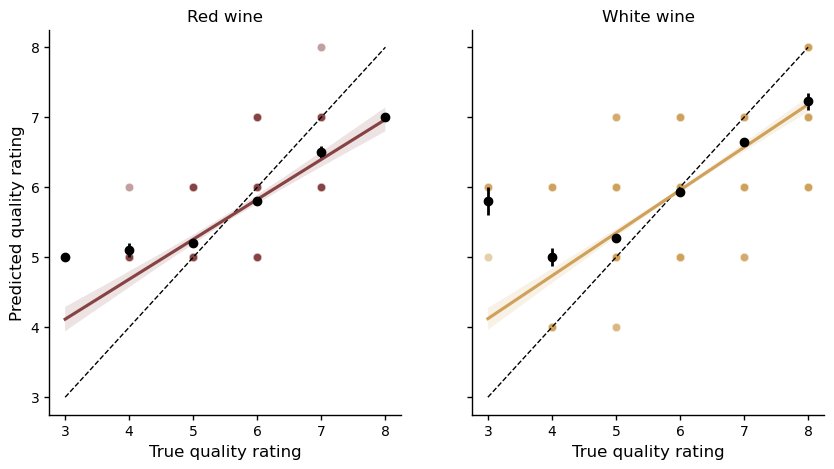

In [32]:
#create DataFrames with true and predicted values
df_red_truepred = pd.DataFrame({'true': y_test_red, 'predicted': y_pred_rf_red})
df_white_truepred = pd.DataFrame({'true': y_test_white, 'predicted': y_pred_rf_white})

#define function to calculate means and standard errors for binned data
def calculate_binned_stats(df):
    unique_true_values = np.unique(df['true'])
    means = []
    std_errors = []
    for value in unique_true_values:
        bin_pred_values = df['predicted'][df['true'] == value]
        mean = bin_pred_values.mean()
        std_error = bin_pred_values.std() / np.sqrt(len(bin_pred_values)) if len(bin_pred_values) > 0 else 0
        means.append(mean)
        std_errors.append(std_error)
    
    summary_df = pd.DataFrame({
        'true': unique_true_values,
        'mean_predicted': means,
        'std_error': std_errors
    })
    
    return summary_df

#run function to calculate summary DataFrames
summary_df_red_truepred = calculate_binned_stats(df_red_truepred)
summary_df_white_truepred = calculate_binned_stats(df_white_truepred)

#define function to make the figure
def plot_predicted_vs_true(df_red, summary_df_red, df_white, summary_df_white):
    
    fig, axs = plt.subplots(1, 2, figsize=(plot_size_onerowwidth*2, plot_size_onerowheight), sharex=True, sharey=True)

    #panel for red wine
    ax = axs[0]
    sns.scatterplot(x='true', y='predicted', data=df_red, color=wine_palette_color['red'], alpha=0.5, ax=ax)
    sns.lineplot(x=[df_red['true'].min(), df_red['true'].max()], y=[df_red['true'].min(), df_red['true'].max()], color='black', linestyle='--', lw=1, ax=ax)
    ax.errorbar(summary_df_red['true'], summary_df_red['mean_predicted'], yerr=summary_df_red['std_error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=0)
    sns.regplot(x='true', y='predicted', data=df_red, scatter=False, color=wine_palette_color['red'], ax=ax)
    ax.set_xlabel('True quality rating')
    ax.set_ylabel('Predicted quality rating')
    ax.set_title('Red wine')
    apply_common_settings(ax)

    #panel for white wine
    ax = axs[1]
    sns.scatterplot(x='true', y='predicted', data=df_white, color=wine_palette_color['white'], alpha=0.5, ax=ax)
    sns.lineplot(x=[df_white['true'].min(), df_white['true'].max()], y=[df_white['true'].min(), df_white['true'].max()], color='black', linestyle='--', lw=1, ax=ax)
    ax.errorbar(summary_df_white['true'], summary_df_white['mean_predicted'], yerr=summary_df_white['std_error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=0)
    sns.regplot(x='true', y='predicted', data=df_white, scatter=False, color=wine_palette_color['white'], ax=ax)
    ax.set_xlabel('True quality rating')
    ax.set_ylabel('Predicted quality rating')
    ax.set_title('White wine')
    apply_common_settings(ax)

    #show figure
    plt.show()

#plot figure using function
plot_predicted_vs_true(df_red_truepred, summary_df_red_truepred, df_white_truepred, summary_df_white_truepred)

The figures above show, for both wine type data, a bunch of things. The black, dashed identity line denotes the path perfect predictions should follow. The colored dots show all the individual predictions. Since predictions are always integers, corresponding to the values of the rating scale, a lot of data points are overlapped, with darker dots revealing the presence of more data. But that overlap won't tell us much. It's better to look at the black dots representing the averages. We can see how those dots tend to follow an ascending progression, meaning that as the true rating increases, so does the average prediction. This is the most fundamental trend to capture, so we can be reassured that our predictions reproduce it. However, it looks like the imaginary line formed by those black dots is not steep enough, meaning that lower ratings tend to be predicted as higher than they are, and higher ratings tend to be predicted as lower. We can see how predictions are much worse on the lower end of the scale, particularly for true ratings of 3. That is understandable when considering the very few number of wines with a true rating of 3, as evidenced by the histogram we plotted at the beginning of our data exploration. The scarcity of such data probably led to a poorer training for those low-rated wines. If we look instread at the linear fit lines, that are made from all the individual data points, we see how it adjusts much better to the identity line than the summary dots, as the latter are more likely to be skewed if some of the averages are made with very little data.

We've learned, then, that the higher the actual rating, the higher our optimized random forest models are likely to predict its rating. That's good. But instead of looking at averages per rating level, we could also see the amount of predictions that do not deviate from the actual ratings, the amount that deviate by one point, the amount that deviates by two,... This can be visualized as a histogram.

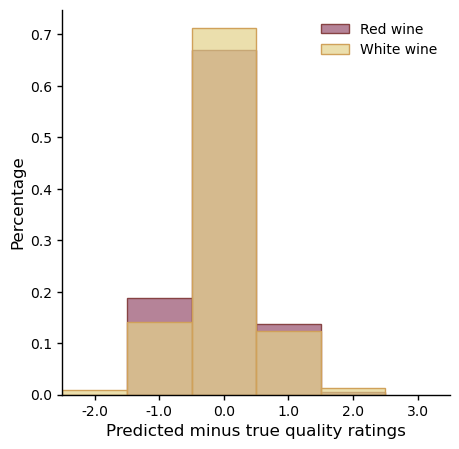

In [33]:
df_red_truepred['dif_predtrue'] = df_red_truepred['predicted'] - df_red_truepred['true']
df_white_truepred['dif_predtrue'] = df_white_truepred['predicted'] - df_white_truepred['true']

#determine bins and midpoints for figure based on unique quality values
bins_red = sorted(df_red_truepred['dif_predtrue'].unique())
bins_white = sorted(df_white_truepred['dif_predtrue'].unique())
bins_unique = sorted(list(set(bins_red + bins_white)))
bins_midpoints = [i + 0.5 for i in bins_unique]

#create a figure
plt.figure(figsize=(plot_size_onerowwidth, plot_size_onerowheight))

#plot histograms
sns.histplot(df_red_truepred['dif_predtrue'], bins=bins_unique, stat='density', color=wine_palette_fill['red'], alpha=0.7, edgecolor=wine_palette_color['red'], label='Red wine')
sns.histplot(df_white_truepred['dif_predtrue'], bins=bins_unique, stat='density', color=wine_palette_fill['white'], alpha=0.7, edgecolor=wine_palette_color['white'], label='White wine')

#customize the plot
plt.xlabel('Predicted minus true quality ratings')
plt.ylabel('Percentage')
plt.legend(frameon=False)

#apply custom theme settings
ax = plt.gca()
apply_common_settings(ax)

#set axes ticks, labels and limits
ax.set_xticks(bins_midpoints)
ax.set_xticklabels(bins_unique)
ax.set_xlim( min(bins_midpoints) - 0.5 , max(bins_midpoints) + 0.5)
ax.set_ylim(0, ax.get_ylim()[1])

#show plot
plt.show()

Good news! The histogram above reveals that around 70% of predictions were identical to the true rating. Almost all the rest of the predicitons deviate from the true values by only one point. At a glance, predictions for the white wine data are more accurate, which is consistent with the MAE of the optimized random forest being also lower.

Finally we'll look into one of the most interesting and meaningful things: how important each physicochemical characteristic is for the best models when predicting quality. We'll do so by calculating feature importance for each predictor. Such importances are scaled so that they add up to 1. These will be visualized as bar plots, where each bar's length corresponds to the feature importance of one predictor. However, knowing the strength of a predictor is not enough, as we also need to know the direction of the effect. For instance, is higher acidity related to higher or to lower quality? In order to visualize the direction of the effect, within each bar we'll include an inset with the coefficient of the correlation between each predictor and true wine ratings, as well as its associated p-value.

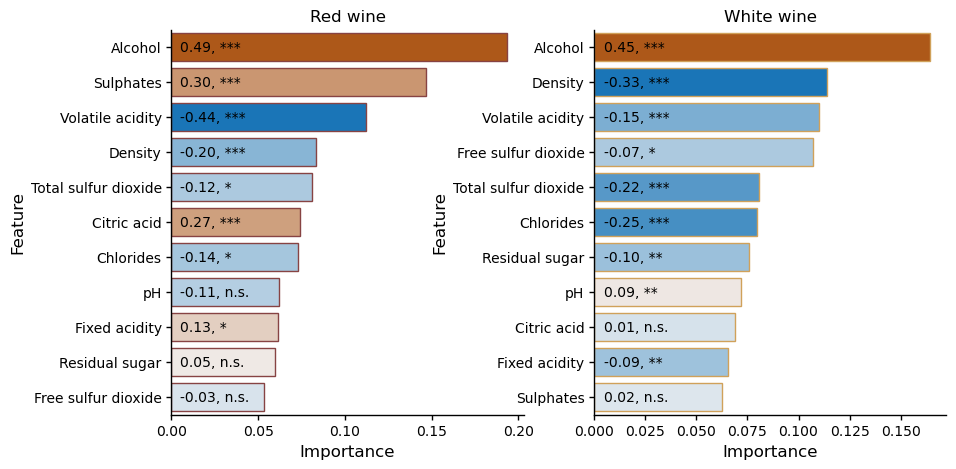

In [34]:
#calculate feature importances and add them to DataFrame
feature_importances_red = best_rf_red.feature_importances_
feature_importances_white = best_rf_white.feature_importances_

features_df_red = pd.DataFrame({
    'Feature': predictors_list,
    'Importance': feature_importances_red
}).sort_values(by='Importance', ascending=False)

features_df_white = pd.DataFrame({
    'Feature': predictors_list,
    'Importance': feature_importances_white
}).sort_values(by='Importance', ascending=False)

#map from column names to labels and add column with labels
features_df_red['label'] = features_df_red['Feature'].map(label_dict)
features_df_white['label'] = features_df_white['Feature'].map(label_dict)

#calculate correlations and p-values and add them to DataFrame
correlations_red = X_test_red.apply(lambda x: pearsonr(x, y_test_red)[0])
pvals_red = X_test_red.apply(lambda x: pearsonr(x, y_test_red)[1])
correlations_white = X_test_white.apply(lambda x: pearsonr(x, y_test_white)[0])
pvals_white = X_test_white.apply(lambda x: pearsonr(x, y_test_white)[1])

features_df_red['Correlation'] = features_df_red['Feature'].map(correlations_red)
features_df_red['p-value'] = features_df_red['Feature'].map(pvals_red)
features_df_white['Correlation'] = features_df_white['Feature'].map(correlations_white)
features_df_white['p-value'] = features_df_white['Feature'].map(pvals_white)

#define function to map correlation to color
def get_color(val, cmap, vmin, vmax):
    norm = plt.Normalize(vmin, vmax)
    return cmap(norm(val))

#define function to get p-value annotation
def get_pval_annotation(pval):
    if pval > 0.05:
        return 'n.s.'
    elif pval >= 0.01:
        return '*'
    elif pval >= 0.001:
        return '**'
    else:
        return '***'

#define function to plot feature importances with correlation and p-values annotations
def plot_feature_importances(df, wine_type, ax, color):
    vmin, vmax = df['Correlation'].min(), df['Correlation'].max()
    
    #sort the DataFrame by importance in descending order
    df = df.sort_values('Importance', ascending=False)
    
    #create a barplot
    sns.barplot(x='Importance', y='label', data=df, palette=[get_color(c, custom_cmap, vmin, vmax) for c in df['Correlation']], ax=ax, hue='label')

    #add annotations
    for i, (importance, correlation, pval) in enumerate(zip(df['Importance'], df['Correlation'], df['p-value'])):
        pval_annotation = get_pval_annotation(pval)
        ax.text(0.005, i, f'{correlation:.2f}, {pval_annotation}', color='black', ha="left", va="center", fontsize = 10)
    
    #customize plot
    for patch in ax.patches:
        patch.set_edgecolor(color)
        patch.set_linewidth(1)

    ax.set_title(f'{wine_type.capitalize()} wine')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    apply_common_settings(ax)

#create a figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(plot_size_onerowwidth*2, plot_size_onerowheight))

#plot with function
plot_feature_importances(features_df_red, 'Red', axes[0], wine_palette_color['red'])
plot_feature_importances(features_df_white, 'White', axes[1], wine_palette_color['white'])

#show figure
plt.show()

There we have it. For each wine type, predictors are ordered according to their importance. In the case of both red and white wine it looks like the most important predictor is alcohol, and the relationship between the predictor and wine quality is positive, meaning that wines with more alcohol content are rated as being better. However, there are some differences across wine types. The second most important predictor for red wine is sulphates, whereas it is the most negligible predictor for white wines. The second most influential predictor for white wine is density, which is also important for red wine, as it takes the fourth position. In both cases, less dense wines are associated with higher quality. For both wine types volatile acidity is the third most important characteristic for the model, with lower volatile acidity making the perceived quality of a wine better. Some physicochemical characteristics, like pH or fixed acidity, rank towards the bottom for both wine types.

Our feature importance analyses link each physicochemical characteristic to the strength that our model gives them in determining perceived wine quality. According to our best models, people prefer wines with more alcohol and less density and acidity. This probably represents the most understandable real-world insight to extract from our project. Such clear results allow us to satisfactorily wrap up.

## 6. Conclusion
This project aimed at using common machine learning models to predict wine quality ratings from wine physicochemical properties. We used a dataset containing information on both those properties and quality ratings for numerous wines pertaining to the red and white varieties of Portuguese vinho verde. 

We explored how 8 different models could explain the red and white wine data, separately. For each model, we conducted a parameter tuning procedure by using grid search. For each unique combination of parameters, we used cross-validation to slice the training set into five folds, and then calculated the MAE across validation sets. The parameter combination leading to the lowest average MAE was extracted and used to retrain the model, now on the whole training set. That model was used to generate predictions on the test set, and model performance was evaluated in terms of how much predicted ratings deviated from true ratings. Initially, a random forest model performed better than linear regression. Hinting at multicolinearity as a possible issue, we applied Principal Component Analysis (PCA), but decided to keep all predictors after seeing that most of the data's variabiliy could not be explained by a very reduced number of principal components. To deal with colinearity in other ways, we then introduced ridge and lasso regression, which penalize predictors. Next we tested recursive feature elimination (RFE), which removes the least predictive features until keeping a prespecified number of predictors, and partial least squares (PLS) regression, which applies dimensionality reduction while taking into account the dependent variable. Then we tested a polynomial features model, which through a polynomial transformation can make a linear model predict non-linear relationships. Upon seeing that none of those models performed better than the initial random forest, we introduced XGBoost, another tree model, but the random forest remained undefeated. Upon inspecting the top predictors of the winning random forest models we discovered that high quality ratings were mainly associated to higher alcohol content, lower density, lower volatile acidity and, for red wine only, more sulphates. 

The fact that the random forest outperformed all linear models is probably due to its robustness and to it not assuming any type of relationship between independent and dependent variables. When compared with the XGBoost, the random forest may have performed better due to the ensemble averaging nature of the former model. A possible continuation to our model comparison could have been the introduction of deep learning models, such as those used with the same dataset by [Cortez et al. (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377), but this would have required discussing the complexity of those models. Despite purposedly only featuring fairly simple models, our final predictions were still quite accurate.

An issue that prevented some of our predictions from being even better was the kind of data we worked with. Indeed, the quality ratings in the dataset, which were made along a 0-to-10 scale, mostly included three values: 5, 6 and 7. Ratings of 4 and 8 were rare, 3 and 9 almost non-existent, and 1, 2, 3 and 10 not being present at all. Of course, this reflects the type of product we're dealing with: a hideous wine will most likely not be commercialized, and raters may be reluctant to give a 10 because that is reserved for perfection. However, this made our predictions worse for such seldom-adjudicated ratings. Such quirks of ratings data must be taken into account when working with it.

Beyond being an exercise in model comparison, this project obtained some interesting results. In brief, it provided another example that, by using machine learning, we can establish the importance of a series of physicochemical properties in making a wine to be perceived as better. This is important because it relates the often highly subjective world of food and beverages ratings to a series of objectively measurable metrics.